# 사전 준비

In [1]:
!pip -q install sentence_transformers
!pip -q install scikit-multilearn
!pip -q install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 50.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 52.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 64.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 KB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 10.7 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('content')

Mounted at content


In [3]:
### 현재 사용중인 경로에 맞게 수정 ###

# 모듈 저장되어있는 경로로 이동
import os
os.chdir('content/MyDrive/AI_Bootcamp/Section_6/CP2/FINAL/sbert_module')

In [4]:
# 학습시 경고 알림 무시용.
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

----

# config.py

- RANDOM_STATE: 랜덤 시드 고정용
- BERT_BATCH_SIZE: SBERT 훈련 시 배치 사이즈
- BERT_EPOCHS: SBERT 훈련 에포크 수
- BATCH_SIZE: 분류기 배치 사이즈
- EPOCHS: 분류기 에포크 수


- MAX_LENGTH: 입력 문장 최대 길이 수 (X)
- N_CLASSES: 사용하는 라벨 키워드 수
- PATIENCE: 분류기 학습 시 조기 종료 


- PRETRAINED_MODEL: 사전 학습 모델
- DATA_PATH: 데이터 경로


- MODEL_CSV_FILE: 학습에 사용될 csv 파일 명
- UPDATE_CSV_FILE: 모델 업데이트시 사용할 csv 파일 명


- SBERT_MODEL_PATH: 학습된 SBERT 모델이 저장될 경로
- SBERT_MODEL_FOLDER: 학습된 SBERT 모델 저장 폴더 이름
- *./SBERT_MODEL_PATH/SBERT_MODEL_FOLDER 로 저장됨*


- CLASSIFIER_MODEL_PATH: 학습된 분류기가 저장될 경로
- CLASSIFIER_MODEL_DATE: 분류기가 저장될 경로 날짜
- CLASSIFIER_MODEL_FILE: 분류기가 저장될 이름
- *./CLASSIFIER_MODEL_PATH/CLASSIFIER_MODEL_DATE/CLASSIFIER_MODEL_FILE 로 저장됨*
- CLASSIFIER_MODEL_NEW_FILE: 모델 업데이트 시 이 이름으로 저장됨


- EVALUATE_CSV_FILE: 평가에 사용될 csv 파일 명, 실제 모델 학습 시에는 이 파일이 아닌 전체 데이터셋에서 랜덤하게 일정 부분을 가져옴
- PREDICT_CSV_FILE: 리뷰 예측에 사용될 파일
- PREDICTED_CSV: 예측이 완료된 파일이 저장될 이름


- TAG_CSV: 식당과 매칭을 위해 필요한 식당+키워드별 점수 파일


- CLASS_NAMES: 사용하는 키워드 (가나다 순)

# 데이터 준비

모든 데이터 파일들은 `data` 폴더 안에 존재해야 합니다.  
학습에 사용되는 파일은 `review`칼럼과 `키워드에 대한 라벨`칼럼이 있어야합니다. 라벨이 있는 칼럼은 추후 칼럼 추가로 변경될 시 config.py 파일의 `N_CLASSES`와 `CLASS_NAMES`을 수정하시면 됩니다.  

모델 학습 전 데이터 로더 생성시 `review`에 대하여만 전처리가 진행되기 때문에 예측 또는 학습하려는 칼럼의 이름이 다르다면 data_setup.py 파일에서 전처리 과정에 사용되는 칼럼을 변경하든지 아니면 데이터 프레임의 칼럼 이름을 변경해주는 작업이 필요합니다.

학습에 사용될 파일들을 지정해줍니다. 만약 모델 학습에 사용될 csv 파일 명이 'labeled_with_none.csv'라면 config.py 에 있는 MODEL_CSV_FILE를 알맞게 수정합니다.

```python
class CFG:
    ...
    MODEL_CSV_FILE = "labeled_with_none.csv"
    ...
```

만약 데이터의 키워드 라벨이 아래 사진처럼 원핫으로 되어있지 않다면 [scikit-learn](https://scikit-learn.org/stable/index.html)의 [MultiLabelBinarizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html)를 참고하시면 됩니다.

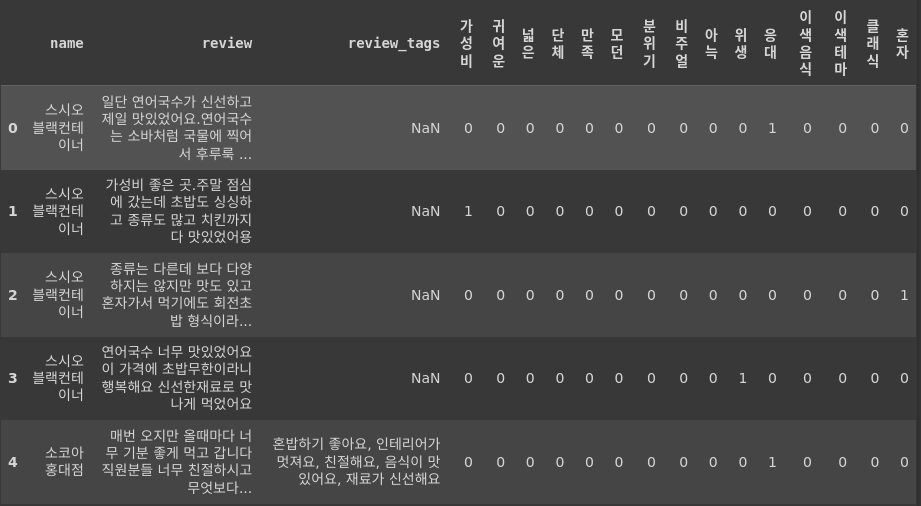

# 학습

## SBERT

SBERT 하이퍼 파라미터 수정은 `sbert_trainer.py` 파일 안에서 수정해주시면 됩니다. 변경할 수 있는 하이퍼 파라미터는 [SentenceTransformer](https://www.sbert.net/docs/package_reference/SentenceTransformer.html#sentence_transformers.SentenceTransformer.fit)에서 확인할 수 있습니다. 간단히 SBERT의 배치사이즈나 에포크를 변경하려면 `config.py`에서 `BERT_BATCH_SIZE`와 `BERT_EPOCHS`를 수정하시면 됩니다.

In [ ]:
# SBERT 모델 훈련 진행
!python sbert_trainer.py

In [6]:
# 학습 완료 후 config.py에 SBERT_MODEL_FOLDER 를 방금 학습으로 생성된 이름으로 변경
# 현재 시각 기준으로 파일 명이 생성되므로 가장 최근 폴더 명을 쓰면 됨
os.listdir('sbert_model')[-1]

'23-02-24_0734'

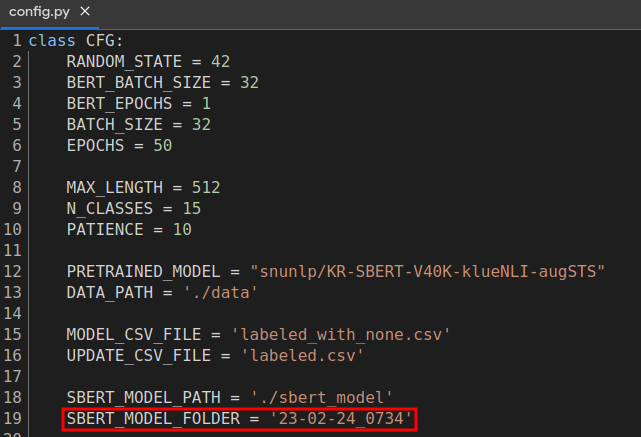

## 분류기

분류기는 `torch`라이브러리를 사용해 구성했습니다. 분류기 구조를 변경하려면 `model_builder.py`에서 `SimpleMLC` 클래스를 수정하시면 됩니다. 

분류기의 옵티마이저, 손실함수는 `trainer.py`에서 정의합니다. 손실함수는 데이터 불균형으로 가중치가 다릅니다. 사용하느 데이터셋에 맞게 수정하시면 됩니다.

학습 과정은 `engine.py`에 작성되어있으며 학습 과정에 추가적인 작업이나 수정이 필요하다면 이 파일을 보시면 됩니다. 한 에포크마다 키워드 라벨별 점수 (f1 점수, roc auc, pr auc)를 출력해줍니다. 출력되는 점수는 `model`폴더 내 분류기가 저장되는 위치에 `runs` 폴더로 저장됩니다. 결과는 텐서보드로 확인 할 수 있습니다.
```
tensorboard --logdir ./model/{모델 저장 폴더 날짜}/runs
```

학습이 완료되었다면 학습이 시작된 시각(`./model/CLASSIFIER_MODEL_PATH/CLASSIFIER_MODEL_DATE`)으로 폴더가 생성되며 그 위치에 `CLASSIFIER_MODEL_FILE`로 학습된 모델의 파라미터들이, runs에 학습 과정들이 저장됩니다.

In [ ]:
# 분류기 학습 진행
!python trainer.py

In [8]:
# SBERT와 마찬가지로 학습 완료 후 config.py에서 CLASSIFIER_MODEL_DATE 수정
# CLASSIFIER_MODEL_FILE도 수정한다면 config.py에서 수정
# CLASSIFIER_MODEL_DATE는 현재 시각 폴더, CLASSIFIER_MODEL_FILE은 저장되는 파일 명
os.listdir('model')[-1]

'23-02-24_0750'

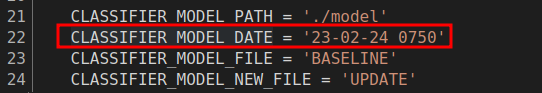

# 예측

In [9]:
# 위 과정대로 학습 완료된 config.py의 SBERT와 분류기의 폴더 이름을 변경했다면
# 아래와 같이 리뷰 한 줄에 대한 키워드별 확률과 그에 맞는 식당이 출력된다.
!python evaluate.py --text "데이트"

[INFO] Load custom trained sbert model.
[0.15039495]
[INFO] Error: Input text is too dissimilar to the dataset
분위기 태그를 가진 식당들을 보여줍니다
+----------+---------------+
|          |   Probability |
|----------+---------------|
| 가성비   |        0.1016 |
| 귀여운   |        0.0674 |
| 넓은     |        0.0933 |
| 단체     |        0.3994 |
| 만족     |        0.3139 |
| 모던     |        0.2870 |
| 분위기   |        0.6782 |
| 비주얼   |        0.1858 |
| 아늑     |        0.3078 |
| 위생     |        0.1728 |
| 응대     |        0.1602 |
| 이색음식 |        0.1636 |
| 이색테마 |        0.2275 |
| 클래식   |        0.2794 |
| 혼자     |        0.3197 |
+----------+---------------+
+------------+--------------------+----------+--------+--------------+----------+
|            |   와인앤파스타0317 |   우디네 |   디엠 |   디벨롭연남 |   이마치 |
|------------+--------------------+----------+--------+--------------+----------|
| 가성비     |             0.0290 |   0.0099 | 0.0337 |       0.0379 |   0.0206 |
| 귀여운     |             0.0000 |   0.0000 | 0.000

한 문장에 대한 예측이 아닌 대량의 리뷰들을 예측하려면 `massive_evaluate.py`파일을 실행하면 됩니다.   
`massive_evaluate.py`는 `config.py`에 `PREDICT_CSV_FILE`로 명시된 csv 파일을 사용하며 이 파일에는 식당 이름인 `name` 칼럼과 `review` 칼럽이 있어야합니다. 다른 칼럼 명을 사용한다면 csv파일의 칼럼명을 수정하거나 massive_evaluate.py에서 사용하는 칼럼 명을 수정하면 됩니다.  
예측 결과는 `data` 폴더 내 (config.py에 명시되어있는)`PREDICTED_CSV`로 저장됩니다.

예측에 사용될 파일은 전처리가 필요합니다. 이 내용은 `Evaluate_all.ipynb` 노트북에 작성되어있습니다. 전처리가 필요하지 않다면 아래와 같이 바로 실행시켜주면 됩니다. (학습시에는 라벨이 적당히 긴 문장에만 부여되었지만 전체 데이터셋에서는 한글만 남길 경우 문장 자체가 삭제되는 경우와 너무 짧은 문장이 있는 경우가 있습니다. 전체 결과에 노이즈로 적용될 수 있으므로 삭제하는 과정이 필요합니다.)

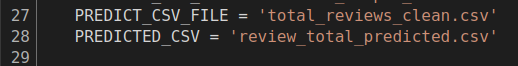

In [29]:
!python massive_evaluate.py

[INFO] Loading Data and Model...
[INFO] Load custom trained sbert model.
[INFO] Done!
[INFO] Evalualting...
100% 1848/1848 [13:35<00:00,  2.27it/s]
[INFO] Predicted csv file saved! './data/review_total_predicted.csv' (819.899s)


In [33]:
temp = pd.read_csv('data/review_total_predicted.csv')

In [37]:
temp.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236542 entries, 0 to 236541
Data columns (total 17 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   name    236542 non-null  object 
 1   review  236542 non-null  object 
 2   가성비     236542 non-null  float64
 3   귀여운     236542 non-null  float64
 4   넓은      236542 non-null  float64
 5   단체      236542 non-null  float64
 6   만족      236542 non-null  float64
 7   모던      236542 non-null  float64
 8   분위기     236542 non-null  float64
 9   비주얼     236542 non-null  float64
 10  아늑      236542 non-null  float64
 11  위생      236542 non-null  float64
 12  응대      236542 non-null  float64
 13  이색음식    236542 non-null  float64
 14  이색테마    236542 non-null  float64
 15  클래식     236542 non-null  float64
 16  혼자      236542 non-null  float64
dtypes: float64(15), object(2)
memory usage: 92.3 MB


---

# 식당 매칭

모든 리뷰마다 예측이 완료되었다면, 식당별로 그룹화 후 식당에 맞는 점수를 출력해주시면 됩니다. 식당마다 점수 출력 과정은 `store_score.ipynb` 파일에 작성되어있습니다.

---

# 모델 업데이트
새로운 데이터가 추가되어 모델을 업데이트 할 경우 `update.py`를 실행하면 됩니다.
```
!python update.py --update
```
업데이트를 위한 파일에는 `review` 칼럼과 `각 키워드에 대한 라벨`이 작성되어 있어야 합니다. 모델이 예상과 달리 업데이트 되는지 확인하기 위해 모델을 학습할 때와 같이 모델이 저장되는 위치에 과정이 기록됩니다.  
위 처럼 `--update`를 넘겨준다면 `config.py` 파일에서 현재 사용하고 있는 SBERT와 분류기의 파일이 변경됩니다. 또한 업데이트 이전의 모델은 삭제됩니다.